# full pipeline for contructing the `haloflow` dataset
In practice, we use the script `bin/make_data.py`, which does the same thing

In [32]:
import os
import h5py, glob
import numpy as np 
from tqdm.notebook import tqdm
from astropy import table as aTable

In [2]:
# -- plotting -- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# 1. compile morphology for subhalos
Compile the following columns
```
col_photo = ['Sersic_mag', 'Sersic_Reff', 'CAS_C', 'CAS_A', 'Sersic_dmag_m', 'Sersic_dmag_p']
col_subhalo = ['SubhaloMassType_stars', 'SubhaloMassType_dm']
```

First, lets combine all the morphology files

In [3]:
dat_dir = '/scratch/gpfs/chhahn/haloflow/'

morph_g = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_G.csv'))
morph_i = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_I.csv'))
morph_r = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_R.csv'))
morph_y = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_Y.csv'))
morph_z = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_Z.csv'))

In [4]:
print('%i morphology' % len(morph_g))

78849 morphology


In [5]:
col_photo = ['Sersic_mag', 'Sersic_Reff', 'CAS_C', 'CAS_A', 'Sersic_dmag_m', 'Sersic_dmag_p']

for morph in [morph_g, morph_i, morph_r, morph_y, morph_z]:
    morph['snapshot'] = [int(dbid.split('_')[1]) for dbid in morph['dbID'].data]
    morph['subhalo_id'] = [int(dbid.split('_')[2]) for dbid in morph['dbID'].data]
    morph['version'] = [dbid.split('_')[3] for dbid in morph['dbID'].data]
    
for band, morph in zip(['g', 'i', 'r', 'y', 'z'], [morph_g, morph_i, morph_r, morph_y, morph_z]): 
    cols = morph.columns.copy()
    for k in cols: 
        if k in col_photo: 
            morph.rename_column(k, '%s_%s' % (band, k))
        elif k in ['snapshot', 'subhalo_id', 'version']: 
            pass
        else: 
            morph.remove_column(k)

In [6]:
for i, morph in enumerate([morph_g, morph_i, morph_r, morph_y, morph_z]): 
    mask = np.zeros(len(morph)).astype(bool)
    for k in morph.columns: 
        try: 
            mask = mask | morph[k].mask
        except AttributeError: 
            pass
        
    if i == 0: 
        morphs = morph.copy()
    else:        
        morphs = aTable.join(morphs, morph[~mask], keys=['snapshot', 'subhalo_id', 'version'], join_type='left')

In [7]:
mask = np.zeros(len(morphs)).astype(bool)
for k in morphs.columns: 
    try: 
        mask = mask | morphs[k].mask
    except AttributeError: 
        pass
morphs = morphs[~mask]

Next, lets match them to the subhalos, by `snapshot` and `subhalo_id`

In [8]:
subhalo = aTable.Table.read(os.path.join(dat_dir, 'Subhalos.csv'))
print('%i subhalos' % len(subhalo))

187978 subhalos


In [9]:
subhalo['snapshot'] = [int(dbid.split('_')[0]) for dbid in subhalo['dbID'].data]
subhalo['subhalo_id'] = [int(dbid.split('_')[1]) for dbid in subhalo['dbID'].data]

In [10]:
subhalos = aTable.join(morphs, subhalo['snapshot', 'subhalo_id', 'SubhaloMassType_stars', 'SubhaloMassType_dm'], 
                       keys=['snapshot', 'subhalo_id'], join_type='left')

In [11]:
# remove subhalos with no DM 
subhalos = subhalos[subhalos['SubhaloMassType_dm'] > 0]

In [12]:
subhalos[:5]

g_Sersic_Reff,g_Sersic_mag,g_Sersic_dmag_m,g_Sersic_dmag_p,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_Sersic_dmag_m,i_Sersic_dmag_p,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_Sersic_dmag_m,r_Sersic_dmag_p,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_Sersic_dmag_m,y_Sersic_dmag_p,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_Sersic_dmag_m,z_Sersic_dmag_p,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.24613,19.1778,-0.0779797,0.046892,3.33779,0.27015,59,0,v0,1.99236,17.9386,-0.00174236,0.00182266,4.5414,0.239801,5.28233,18.5249,-0.00385797,0.00355385,3.97973,0.239256,1.37891,17.5674,-0.00361839,0.00339944,4.18415,0.112956,1.97202,17.6489,-0.00287083,0.00251571,4.20004,0.154838,12.1272,13.8103
11.6712,19.0432,-0.0425542,0.0731264,3.22296,0.364432,59,0,v1,6.57865,17.6822,-0.00529423,0.00438403,4.48597,0.292787,4.46632,18.8765,-0.0472835,0.012885,3.87586,0.250358,2.25006,17.5264,-0.00579206,0.0070568,4.22799,0.12975,2.76786,17.6744,-0.00346853,0.0040452,4.91712,0.22512,12.1272,13.8103
6.29045,19.1097,-0.0219538,0.0249799,3.24656,0.390166,59,0,v3,1.2414,17.9188,-0.00291304,0.00337726,4.72038,0.247056,5.83477,18.22,-0.00423978,0.00453768,4.37358,0.194555,0.793874,17.6673,-0.00662935,0.00673421,3.72926,0.0387591,1.3203,17.594,-0.00594847,0.0057911,4.17379,0.122474,12.1272,13.8103
6.1195,19.7286,-0.00522288,0.00495322,2.82971,0.410775,59,0,v2,3.60767,18.5171,-0.0027119,0.00272167,3.21209,0.263637,4.69163,19.2032,-0.00338622,0.00370766,2.96856,0.347073,2.45257,18.3693,-0.00816445,0.00805607,2.72622,0.343008,3.19436,18.3335,-0.00432735,0.00447652,3.22296,0.294881,12.1272,13.8103
1.09169,21.8644,-0.0166642,0.0164959,2.7975,0.0526816,59,1,v0,2.78929,18.8237,-0.0116263,0.0114589,3.74536,0.0654512,1.72633,20.2486,-0.0190367,0.0413142,3.45521,0.0714894,1.54465,18.4721,-0.0257487,0.0244008,3.30828,-0.0680968,2.2398,18.5473,-0.0189426,0.0166284,3.54191,0.0137252,11.6411,12.2768


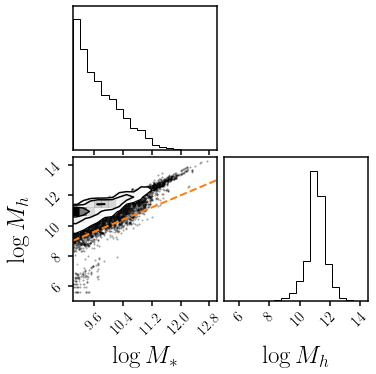

In [13]:
fig = DFM.corner(np.array([np.array(subhalos[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T, 
               range=[(9., 13.), (5., 14.5)],
              labels=[r'$\log M_*$', r'$\log M_h$'],
              label_kwargs={'fontsize': 25})
fig.axes[2].plot([9., 13.], [9., 13.], c='C1', ls='--', linewidth=2)

In [14]:
del subhalo

# 2. Compile group properties
In particular, we identify central galaxies then calculate the satellite luminosity and richness

In [15]:
snapshot = 91 # z = 0.1 https://www.tng-project.org/data/docs/specifications/#sec1

In [16]:
is_snap  = (subhalos['snapshot'] == snapshot)
subhalos = subhalos[is_snap]
print('%i subhalos in snapshot %i' % (len(subhalos), snapshot)) 

12188 subhalos in snapshot 91


In [17]:
grp_dir = '/scratch/gpfs/chhahn/haloflow/groupcat/idark.ipmu.jp/hsc405/GroupCats/groups_0%i/' % snapshot

h = 0.6773358287273804

# compile subhalos and groups
tab_sub, tab_grp = [], []
for i in range(np.max([int(fsub.split('.')[-2]) for fsub in glob.glob(os.path.join(grp_dir, '*.hdf5'))])+1):
    with h5py.File(os.path.join(grp_dir, 'fof_subhalo_tab_0%i.%i.hdf5' % (snapshot, i)), 'r') as fsub:
        _tab = aTable.Table()
        for k in fsub['Subhalo'].keys():
            _tab[k] = fsub['Subhalo'][k][...]
        tab_sub.append(_tab)

        _tab = aTable.Table()
        for k in fsub['Group'].keys():
            _tab[k] = fsub['Group'][k][...]
        tab_grp.append(_tab)

tab_sub = aTable.vstack(tab_sub)
tab_grp = aTable.vstack(tab_grp)

identify the centrals

In [19]:
central_subid = tab_grp['GroupFirstSub'][tab_grp['GroupFirstSub'] != -1]
is_central = np.array([_id in central_subid for _id in subhalos['subhalo_id']])
print('%i centrals out of %i subhalos' % (np.sum(is_central), len(is_central)))

centrals = subhalos[is_central]

7468 centrals out of 12188 subhalos


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$M_r$')

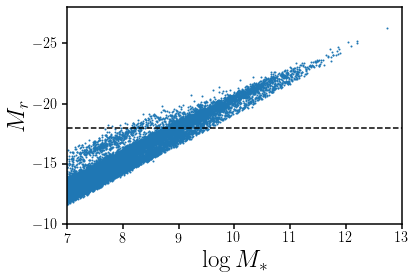

In [30]:
plt.scatter(np.log10(tab_sub['SubhaloMassType'][:,4] * 10**10 / h), tab_sub['SubhaloStellarPhotometrics'][:,5], s=1)
plt.plot([7., 13], [-18, -18], c='k', ls='--')
plt.xlabel('$\log M_*$', fontsize=25)
plt.xlim(7, 13)
plt.ylim(-10, -28)
plt.ylabel('$M_r$', fontsize=25)

In [34]:
# compile satellite luminosities 
lum_has_stars = np.zeros((len(centrals), 4))
lum_above_mlim = np.zeros((len(centrals), 4))
lum_above_mrlim = np.zeros((len(centrals), 4))
richness_all = np.zeros(len(centrals))
richness_mlim = np.zeros(len(centrals))
richness_mrlim = np.zeros((len(centrals), 4))

has_stars = tab_sub['SubhaloMassType'][:,4] > 0
above_mlim = np.log10(tab_sub['SubhaloMassType'][:,4] * 10**10 / h) > 9.
above_mrlim = tab_sub['SubhaloStellarPhotometrics'][:,5] < -18

for i_sub in tqdm(np.unique(centrals['subhalo_id'])):
    i_grp = tab_sub['SubhaloGrNr'][i_sub]
    in_group = (tab_sub['SubhaloGrNr'] == i_grp) & (np.arange(len(tab_sub)) != i_sub)

    # g, r, i, z
    is_sub = (centrals['subhalo_id'] == i_sub)
    lum_has_stars[is_sub,:] = np.tile(
        np.sum(10**(-0.4 * tab_sub[in_group & has_stars]['SubhaloStellarPhotometrics'][:,4:]), 
            axis=0),
        (np.sum(is_sub),1))
    lum_above_mlim[is_sub,:] = np.tile(
        np.sum(10**(-0.4 * tab_sub[in_group & above_mlim]['SubhaloStellarPhotometrics'][:,4:]), 
            axis=0),
        (np.sum(is_sub),1))
    lum_above_mrlim[is_sub,:] = np.tile(
        np.sum(10**(-0.4 * tab_sub[in_group & above_mrlim]['SubhaloStellarPhotometrics'][:,4:]), 
            axis=0),
        (np.sum(is_sub),1))
    
    richness_all[is_sub]    = np.sum(in_group & has_stars)
    richness_mlim[is_sub]   = np.sum(in_group & above_mlim)
    richness_mrlim[is_sub]   = np.sum(in_group & above_mrlim)    

for i, b in enumerate(['g', 'r', 'i', 'z']): 
    centrals['%s_lum_has_stars' % b] = lum_has_stars[:,i]
    centrals['%s_lum_above_mlim' % b] = lum_above_mlim[:,i]
    centrals['%s_lum_above_mrlim' % b] = lum_above_mrlim[:,i]

centrals['richness_all'] = richness_all
centrals['richness_mlim'] = richness_mlim
centrals['richness_mrlim'] = richness_mrlim

centrals.write(os.path.join(dat_dir, 'subhalos.central.snapshot%i.hdf5' % snapshot), overwrite=True)

# set up training and test data sets 
uid = np.random.choice(np.unique(subhalo['subhalo_id'][subhalo['SubhaloMassType_stars'] > 9.5]), 
                       replace=False, size=125)

i_test = np.zeros(len(subhalo)).astype(bool)
for _uid in uid:
    i_test[subhalo['subhalo_id'] == _uid] = True

print('%s test subhalos' % np.sum(i_test))
test_subhalos = subhalo[i_test]
train_subhalos = subhalo[~i_test]

test_subhalos.write(os.path.join(dat_dir, 'subhalos.central.snapshot%i.v1.test.hdf5' % snapshot), overwrite=True)
train_subhalos.write(os.path.join(dat_dir, 'subhalos.central.snapshot%i.v1.train.hdf5' % snapshot), overwrite=True)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1867 [00:00<?, ?it/s]

KeyboardInterrupt: 